# (05) Align (within & across) -- perm

**Motivation**: Alignment scores (using permutation importance) within and across model classes. Use active latents only. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Load, xtract z

In [2]:
%%time

model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
fit_names = {
    1: 's1_ep160-b600-lr(0.002)_beta(1:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_08_03,22:56)',
    2: 's2_ep160-b600-lr(0.002)_beta(1:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_08_03,22:56)',
    3: 's3_ep160-b600-lr(0.002)_beta(1:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_08_03,22:56)',
}

thres = 0.01
active = {}
z_vld, z_tst = {}, {}

for seed, fit_name in fit_names.items():
    tr, meta = load_model(
        model_name=model_name,
        fit_name=fit_name,
        device='cuda:1',
    )
    assert meta['checkpoint'] == 160
    loss = tr.forward('vld', False)[1]
    active[seed] = loss['kl_diag'] > thres
    z_vld[seed] = tr.forward('vld', True)[0]['z']
    z_tst[seed] = tr.forward('tst', True)[0]['z']

CPU times: user 3min 21s, sys: 8.59 s, total: 3min 29s
Wall time: 2min 39s


## Analyze

In [3]:
src = 1
tgt = 2
x_vld, y_vld = z_vld[src], z_vld[tgt]
x_tst, y_tst = z_tst[src], z_tst[tgt]
active_ids = np.where(active[tgt])[0]

In [10]:
shape = (len(active_ids), x_vld.shape[1])
importances_mu = np.zeros(shape)
importances_sd = np.zeros(shape)

for i, latent_id in tqdm(enumerate(active_ids), total=len(active_ids)):
    _lr = sk_linear.LinearRegression().fit(
        x_vld, y_vld[:, latent_id])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=x_tst,
        y=y_tst[:, latent_id],
        n_repeats=5,
        random_state=0,
    )
    importances_mu[i] = result.importances_mean
    importances_sd[i] = result.importances_std

In [22]:
w = np.maximum(0, importances_mu)
w /= w.sum(1, keepdims=True)

a = 1 - entropy_normalized(w, axis=1)

<Axes: ylabel='Count'>

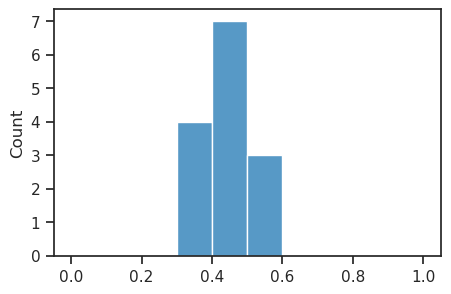

In [25]:
sns.histplot(a, bins=np.linspace(0, 1, 11))

In [27]:
np.mean(a), np.median(a)

(0.4392645200823514, 0.4270666466989281)

In [28]:
lr = sk_linear.LinearRegression().fit(x_vld, y_vld)
pred = lr.predict(x_tst)

In [30]:
r = 1 - sp_dist.cdist(
    XA=pred.T,
    XB=y_tst.T,
    metric='correlation',
)
r2 = sk_metric.r2_score(
    y_pred=pred,
    y_true=y_tst,
    multioutput='raw_values',
)

In [31]:
r.shape, r2.shape

((420, 420), (420,))

In [32]:
r2.mean()

0.9087022928245043

<Axes: ylabel='Count'>

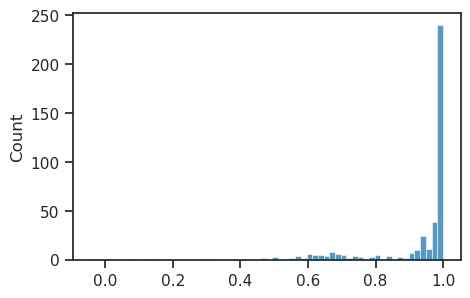

In [33]:
sns.histplot(r2)